In [1]:
!nvidia-smi

Mon Dec 13 15:14:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   36C    P0    68W / 250W |      0MiB / 45556MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 torchaudio==0.8.0 -f https://download.pytorch.org/whl/torch_stable.html


In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import io
import imageio
import pickle 
import cv2
from skimage.metrics import structural_similarity as ssim
import sys
from ipywidgets import widgets, HBox

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C

In [3]:
class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        #print(X.size())
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, 
        height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, 
        height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, 
        height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:,time_step] = H

        return output

In [4]:
class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Sigmoid()(output)

In [7]:
# import os, os.path, glob

# #Radar = np.zeros((458, 250, 501, 501))
# file_counter = 0
# global_ans = []
# gc=0
# for foldername in os.listdir("nh_radar_comp_echo/"):
#     if foldername=='.DS_Store':
#         continue
# #     if gc>=5:
# #         break
#     gc+=1
#     list = os.listdir("nh_radar_comp_echo/"+foldername) # dir is your directory path
#     number_files = len(list)
#     print(gc, ": ", number_files)
#     if number_files<240:
#         continue
#     file_counter+=1
#     ls = []
#     counter = 0 
#     for filename in sorted(os.listdir("nh_radar_comp_echo/"+foldername)):
#         if counter>=240:
#             break
#         counter+=1
#         #print(foldername+"/"+filename)
#         #img = Image.open("nh_radar_comp_echo/"+foldername+"/"+filename)
#         img = cv2.imread("nh_radar_comp_echo/"+foldername+"/"+filename, cv2.IMREAD_GRAYSCALE) 
#         img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
#         np_img = np.array(img)
#         #Radar[file_counter-1][counter-1] = np_img
#         #print(np_img.shape)
#         ls.append(np_img)
#     f = np.asarray(ls)
#     #print(type(f))
#     global_ans.append(f)
# Radar3 = np.asarray(global_ans)
# np.save('new_radar_data_240_split', Radar3)


In [8]:
#print('number of files', file_counter)

In [9]:
# Radar2 = np.load('new_radar_data_240_split.npy')
# print(Radar2.shape)

In [10]:
# Radar2.resize((5784, 20, 128, 128))

In [11]:
# print(np.max(Radar2))
# print(np.min(Radar2))

In [12]:
# from scipy.stats import iqr

# op = []
# for i in range(0, 5725):
#     for j in range(0, 20):
#         op.append(np.sum(Radar2[i][j]))
        
# st = np.asarray(op)
# print(st.shape)

In [13]:
# print(st)
# st = np.sort(st)
# print(st)

In [14]:
# n25 = np.percentile(st, 25)
# n75 = np.percentile(st, 75)

# print(n25, n75)

In [15]:
# gl = []
# maxp = -1
# minp = sys.maxsize
# for i in range(0, 5725):
#     no_bad = 0;
#     for j in range(0, 20):
#         sum_fr = np.sum(Radar2[i][j])
#         if sum_fr<n25 or sum_fr>n75:
#             no_bad+=1
#     if no_bad<=10:
#         gl.append(Radar2[i])
# Radar = np.asarray(gl)

In [16]:
# np.save('new_radar_20_128fr_cleaned', Radar)

In [5]:
Radar = np.load('new_radar_20_128fr_cleaned.npy')

In [6]:
print(type(Radar))
print(Radar.shape)
print(Radar.itemsize)

<class 'numpy.ndarray'>
(2901, 20, 128, 128)
1


In [7]:
#np.random.shuffle(Radar)
print(Radar.shape)

(2901, 20, 128, 128)


In [8]:
# Train, Test, Validation splits
train_data = Radar[:2000]         
val_data = Radar[2000:2500]       
test_data = Radar[2500:2900]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(15,20)                     
    return batch[:,:,rand-15:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=2, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=2, collate_fn=collate)

In [10]:
input, _ = next(iter(val_loader))

In [11]:
print(type(input))
print(input.shape)

<class 'torch.Tensor'>
torch.Size([2, 1, 15, 128, 128])


In [12]:
input = input.cpu().numpy() * 255.0

(128, 128)


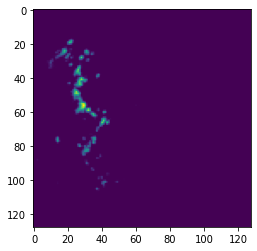

(128, 128)


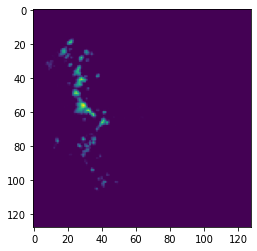

(128, 128)


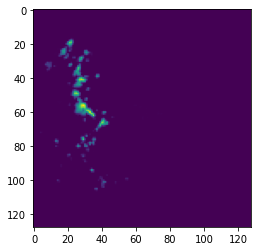

(128, 128)


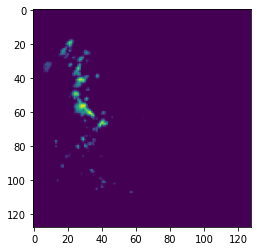

(128, 128)


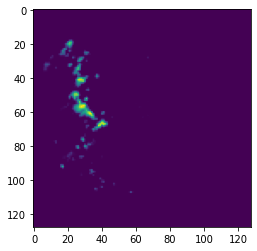

(128, 128)


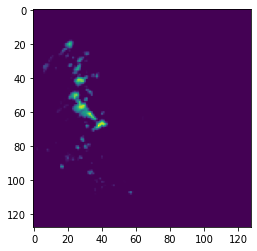

(128, 128)


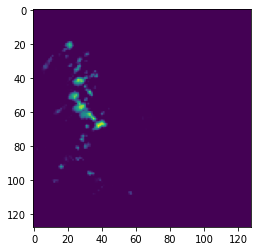

(128, 128)


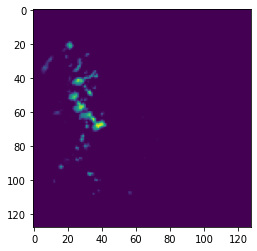

(128, 128)


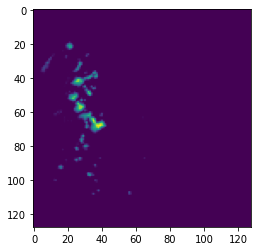

(128, 128)


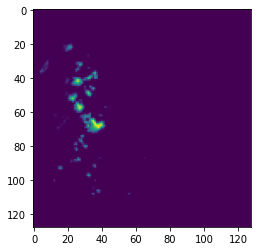

(128, 128)


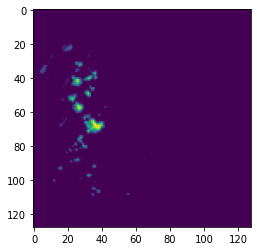

(128, 128)


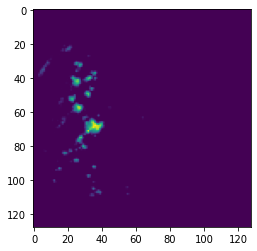

(128, 128)


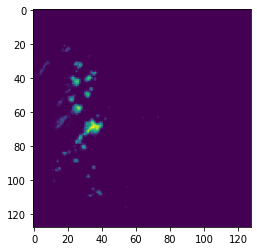

(128, 128)


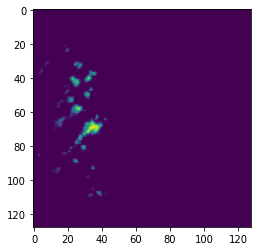

(128, 128)


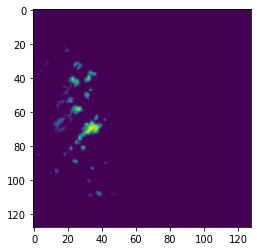

In [13]:
import matplotlib.pyplot as plt

for i in range(0, 15):
    print(input[0][0][i].shape)
    plt.imshow(input[0][0][i])
    plt.show()

In [14]:
for video in input.squeeze(1)[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF",fps=2)
        display(HBox([widgets.Image(value=gif.getvalue(), height=200, width=200)]))

In [10]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(128, 128), num_layers=3).to(device)

optim = Adam(model.parameters(), lr=1e-3)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.MSELoss(reduction='sum')

# class LogCoshLoss(nn.Module):
#     def __init__(self):
#         super().__init__()

#     def forward(self, y_t, y_prime_t):
#         ey_t = y_t - y_prime_t
#         return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))

    
# criterion = LogCoshLoss()

In [15]:
def calculate_psnr(target, output):
    """
    Calculate Peak Signal To Noise Ratio
    Input: torch tensor of shape (m, C, H, W)
    Output: average of PSTR for that batch
    """
    
    m, C, H, W = target.shape
    sum_psnr = 0 
    
    for i in range(m):
        output[i] = torch.clamp(output[i], min=0.0, max=1.0)
        mse = torch.sum((target[i] - output[i])**2)/(C*H*W)
        psnr =  -10*torch.log10(mse)
        sum_psnr += psnr
        
    return sum_psnr

In [16]:
num_epochs = 5

epi=0
ep = []
tr_loss = []
va_loss = []
for epoch in range(1, num_epochs+1):
    epi+=1
    ep.append(epi)
    train_loss = 0  
    psnr_train = 0
    psnr_val =0
    ssim_train = 0
    ssim_val = 0
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        output = model(input)  
        #print(output)
        #print(output.shape)
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()
        psnr_train+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        #print(ot.shape, tt.shape)
        ssim_train+=ssim(ot.detach().numpy(), tt.detach().numpy())
    train_loss /= len(train_loader.dataset)    
    psnr_train/= len(train_loader.dataset) 
    ssim_train/=len(train_loader.dataset)
    tr_loss.append(train_loss)
    
    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:                          
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()     
            psnr_val+=calculate_psnr(target, output)
            ot = output.flatten().cpu()
            tt = target.flatten().cpu()
            ssim_val+=ssim(ot.detach().numpy(), tt.detach().numpy())
    val_loss /= len(val_loader.dataset)
    psnr_val/= len(val_loader.dataset)
    ssim_val/=len(val_loader.dataset)
    va_loss.append(val_loss)
    print("Epoch:{} Training Loss:{:.2f} psnr_train:{:.2f} ssim_train:{:.2f} Validation Loss:{:.2f} psnr_val:{:.2f} ssim_val:{:.2f}\n".format(
        epoch, train_loss, psnr_train, ssim_train, val_loss, psnr_val, ssim_val))
    
    #filename = 'ConvLSTM_{e}_128_20_4000.sav'.format(e=str(epoch))
    #if epi%5==0:
        #pickle.dump(model, open(filename, 'wb'))

Epoch:1 Training Loss:8.11 psnr_train:39.39 ssim_train:0.97 Validation Loss:8.50 psnr_val:40.58 ssim_val:0.98

Epoch:2 Training Loss:8.22 psnr_train:39.30 ssim_train:0.96 Validation Loss:11.43 psnr_val:33.15 ssim_val:0.65

Epoch:3 Training Loss:8.08 psnr_train:39.42 ssim_train:0.96 Validation Loss:8.44 psnr_val:40.05 ssim_val:0.97

Epoch:4 Training Loss:8.03 psnr_train:39.60 ssim_train:0.96 Validation Loss:8.52 psnr_val:38.26 ssim_val:0.94

Epoch:5 Training Loss:8.38 psnr_train:39.89 ssim_train:0.97 Validation Loss:8.34 psnr_val:39.47 ssim_val:0.96



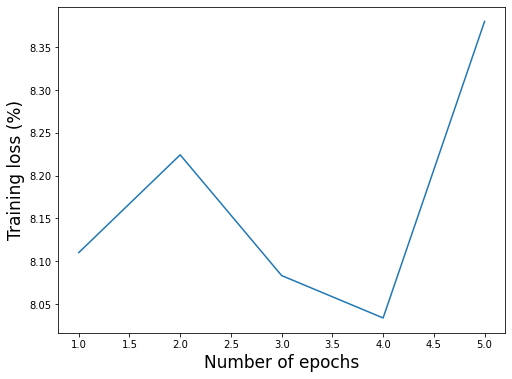

In [20]:
from matplotlib import pyplot as plt
f= plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Training loss (%)", fontsize = 17)


plt.plot(ep, tr_loss)
plt.show()

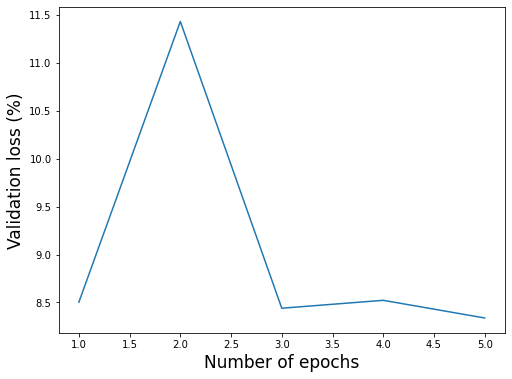

In [21]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Validation loss (%)", fontsize = 17)


plt.plot(ep, va_loss)
plt.show()

In [22]:
# Pkl_Filename = "MIDNIGHT_psnr_ssim_modelConv_LSTM_5_1bs.pkl"  

# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(model, file)

In [9]:
with open('MIDNIGHT_psnr_ssim_modelConv_LSTM_5_1bs.pkl', 'rb') as file:  
    model = pickle.load(file)

In [10]:
def collate_test(batch):

    # Last 15 frames are target
    target = np.array(batch)[:,15:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=1, collate_fn=collate_test)

# Get a batch
batch, target = next(iter(test_loader))



In [11]:
# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)

# Loop over timesteps
for timestep in range(target.shape[1]):
    input = batch[:,:,timestep:timestep+15]
    last_out = model(input).squeeze(1).cpu()
    batch[:,:,timestep+15] = torch.unsqueeze(last_out, dim=1)
    output[:,timestep]=(last_out>0.02)*255.0

In [12]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 2)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 2)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif, height=400, width=400), 
                  widgets.Image(value=output_gif, height=400, width=400)]))
    #(widgets.Image(value=target_gif, height=400, width=400)).save()


In [16]:
test_loader_nu = DataLoader(test_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

ssim_test = 0
psnr_test = 0

model.eval()                                                   
with torch.no_grad():                                          
    for input, target in test_loader_nu:  
        #input = np.squeeze(input, axis=1)
        output = model(input)   
        output = torch.mean(output, 1)
        output = torch.unsqueeze(output, dim=1) 
        psnr_test+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        ssim_test+=ssim(ot.detach().numpy(), tt.detach().numpy())
psnr_test/= len(test_loader_nu.dataset)
ssim_test/=len(test_loader_nu.dataset)
print("PSNR for test dataset: {:.2f}", psnr_test)
print("SSIM for test dataset: {:.2f}", ssim_test)

PSNR for test dataset: {:.2f} tensor(40.8852, device='cuda:0')
SSIM for test dataset: {:.2f} 0.9709706284552836
